<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/daging_sapi_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## load data

In [2]:
url = 'https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f34a2ececd0>)

In [3]:
dataset = pd.read_csv('data_pangan.csv', index_col='date', parse_dates=True)
dataset

,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,daging_sapi_kualitas_2,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
date,,,,,,,,,,,,,,,,,,,,,
2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,111550,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,109850,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,113650,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,111550,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,111150,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,11800,10750,10500,11800,11600,13100,12650,35650,128700,119350,...,49750,44950,53000,18750,17500,19750,18400,14800,15550,14250
2022-11-03,11800,10750,10450,11800,11600,13100,12650,36250,130950,121850,...,60250,47900,72400,19350,17050,20600,19550,14750,15450,14200
2022-11-04,11800,10700,10450,11800,11600,13100,12650,37500,133850,124200,...,52400,46350,57200,24300,19900,26400,25550,15250,15850,14750


In [4]:
train = dataset.daging_sapi_kualitas_1.values
date = dataset.index.values

## train_split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'jumlah train data = {len(x_train)}\njumlah test data = {len(x_test)}\njumlah data validation = {len(x_val)}')

jumlah train data = 818
jumlah test data = 234
jumlah data validation = 117


## data generator

In [6]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

In [7]:
scal_range = MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))

data_train = time_step_generator(train_scal, time_size=400, shuffle_data=100, batch_size=5)
data_val = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=2)
data_test = time_step_generator(test_scal, time_size=100, shuffle_data=100, batch_size=5)

In [8]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
# win_size= 400
# win_size1 = 60
win_size=150
test_dagingsapi1_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## modeling

### model 1

In [9]:
model = Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Adam

In [10]:
model.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae', 'mape'])

In [11]:
history = model.fit(data_train, epochs=50, validation_data=data_val)

Epoch 1/50
84/84 [==============================] - 19s 36ms/step - loss: 0.0185 - mae: 0.0835 - mape: 21.6460 - val_loss: 0.0547 - val_mae: 0.1902 - val_mape: 50.2999
Epoch 2/50
84/84 [==============================] - 1s 17ms/step - loss: 0.0044 - mae: 0.0378 - mape: 9.8776 - val_loss: 0.0575 - val_mae: 0.1974 - val_mape: 50.0902
Epoch 3/50
84/84 [==============================] - 1s 16ms/step - loss: 0.0045 - mae: 0.0380 - mape: 10.0745 - val_loss: 0.0537 - val_mae: 0.1871 - val_mape: 50.3247
Epoch 4/50
84/84 [==============================] - 1s 16ms/step - loss: 0.0046 - mae: 0.0390 - mape: 10.2282 - val_loss: 0.0515 - val_mae: 0.1791 - val_mape: 50.4907
Epoch 5/50
84/84 [==============================] - 1s 17ms/step - loss: 0.0045 - mae: 0.0379 - mape: 9.9427 - val_loss: 0.0522 - val_mae: 0.1820 - val_mape: 50.3875
Epoch 6/50
84/84 [==============================] - 1s 17ms/step - loss: 0.0047 - mae: 0.0377 - mape: 10.0294 - val_loss: 0.0542 - val_mae: 0.1885 - val_mape: 50.1996

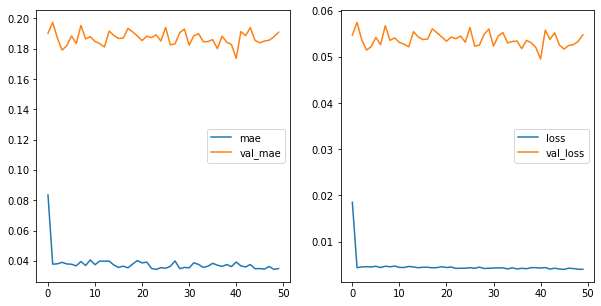

In [12]:
mae_hist = history.history['mae']
val_mae_hist = history.history['val_mae']
loss_hist = history.history['loss']
val_loss_hist = history.history['val_loss']

epochs = range(len(mae_hist))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, mae_hist, label='mae')
plt.plot(epochs, val_mae_hist, label='val_mae')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_hist, label='loss')
plt.plot(epochs, val_loss_hist, label='val_loss')
plt.legend()

181/181 [==============================] - 1s 5ms/step
mae 3181.608642578125
mape 2.441901922225952
rmse 3943.784476869901


,actual,prediction
0,129550,125456.929688
1,128900,125343.742188
2,128500,125455.906250
3,128350,125315.007812
4,127950,125400.828125
...,...,...
229,128700,125545.914062
230,130950,125183.734375
231,133850,125549.492188
232,128450,125169.718750


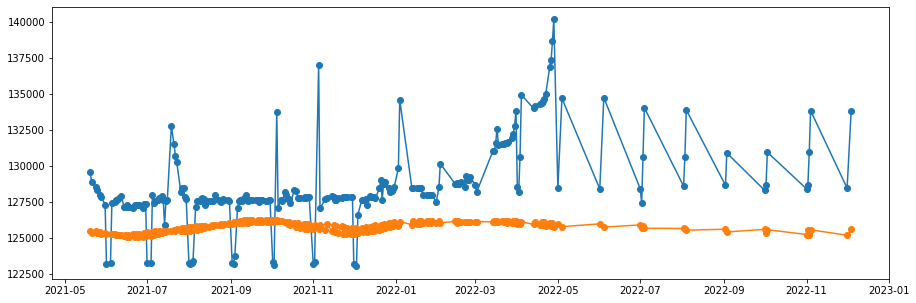

In [13]:
prediction_1_adam = forecast_predict(model, test_dagingsapi1_, time_size=win_size, batch_size=5)
data_result_1_adam = prediction_1_adam[(len(x_train)) - win_size:-1, -1]
data_result_1_adam = scal_range.inverse_transform(data_result_1_adam.reshape(-1, 1))
data_result_1_adam = data_result_1_adam.reshape(-1)
mae_1_adam = mean_absolute_error(x_test, data_result_1_adam)
mape_1_adam = mean_absolute_percentage_error(x_test, data_result_1_adam)
mse_1_adam = mean_squared_error(x_test, data_result_1_adam)
rmse_1_adam = math.sqrt(mse_1_adam)

print(f'mae {mae_1_adam.numpy()}\nmape {mape_1_adam.numpy()}\nrmse {rmse_1_adam}')

data_1_adam = pd.DataFrame()
data_1_adam['actual'] = x_test
data_1_adam['prediction'] = data_result_1_adam
data_1_adam.to_csv('dagingsapi1_1_adam.csv')

plt.figure(figsize=(15,5))
plt.plot(y_test, data_1_adam.actual, '-o', label='actual')
plt.plot(y_test, data_1_adam.prediction, '-o',label='prediction')
data_1_adam

#### SGD

In [14]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])

In [15]:
history1 = model.fit(data_train, epochs=50, validation_data=data_val)

Epoch 1/50
84/84 [==============================] - 5s 25ms/step - loss: 0.0041 - mae: 0.0341 - mape: 9.2029 - val_loss: 0.0551 - val_mae: 0.1919 - val_mape: 50.2070
Epoch 2/50
84/84 [==============================] - 2s 19ms/step - loss: 0.0041 - mae: 0.0341 - mape: 9.1662 - val_loss: 0.0553 - val_mae: 0.1925 - val_mape: 50.1926
Epoch 3/50
84/84 [==============================] - 1s 17ms/step - loss: 0.0040 - mae: 0.0342 - mape: 9.1593 - val_loss: 0.0555 - val_mae: 0.1930 - val_mape: 50.1837
Epoch 4/50
84/84 [==============================] - 1s 17ms/step - loss: 0.0040 - mae: 0.0342 - mape: 9.1581 - val_loss: 0.0555 - val_mae: 0.1932 - val_mape: 50.1821
Epoch 5/50
84/84 [==============================] - 1s 17ms/step - loss: 0.0040 - mae: 0.0343 - mape: 9.1576 - val_loss: 0.0556 - val_mae: 0.1933 - val_mape: 50.1813
Epoch 6/50
84/84 [==============================] - 1s 17ms/step - loss: 0.0040 - mae: 0.0342 - mape: 9.1368 - val_loss: 0.0556 - val_mae: 0.1933 - val_mape: 50.1840
Epoc

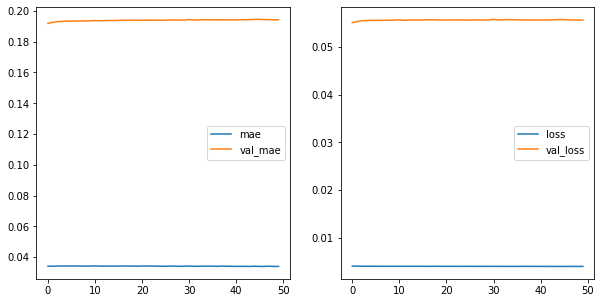

In [16]:
mae_hist_1 = history1.history['mae']
val_mae_hist_1 = history1.history['val_mae']
loss_hist_1 = history1.history['loss']
val_loss_hist_1 = history1.history['val_loss']

epochs_1 = range(len(mae_hist_1))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_1, mae_hist_1, label='mae')
plt.plot(epochs_1, val_mae_hist_1, label='val_mae')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_1, loss_hist_1, label='loss')
plt.plot(epochs_1, val_loss_hist_1, label='val_loss')
plt.legend()

181/181 [==============================] - 1s 5ms/step
mae 3250.70654296875
mape 2.4954562187194824
rmse 3996.75318227183


,actual,prediction
0,129550,125132.515625
1,128900,125020.343750
2,128500,125122.742188
3,128350,124990.375000
4,127950,125062.015625
...,...,...
229,128700,125473.078125
230,130950,125029.710938
231,133850,125473.296875
232,128450,125009.625000


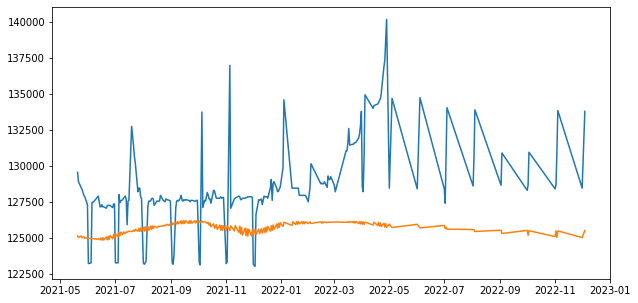

In [17]:
prediction_1_sgd = forecast_predict(model, test_dagingsapi1_, time_size=win_size, batch_size=5)
data_result_1_sgd = prediction_1_sgd[(len(x_train)) - win_size:-1, -1]
data_result_1_sgd = scal_range.inverse_transform(data_result_1_sgd.reshape(-1, 1))
data_result_1_sgd = data_result_1_sgd.reshape(-1)
mae_1_sgd = mean_absolute_error(x_test, data_result_1_sgd)
mape_1_sgd = mean_absolute_percentage_error(x_test, data_result_1_sgd)
mse_1_sgd = mean_squared_error(x_test, data_result_1_sgd)
rmse_1_sgd = math.sqrt(mse_1_sgd)

print(f'mae {mae_1_sgd.numpy()}\nmape {mape_1_sgd.numpy()}\nrmse {rmse_1_sgd}')

data_1_sgd = pd.DataFrame()
data_1_sgd['actual'] = x_test
data_1_sgd['prediction'] = data_result_1_sgd
data_1_sgd.to_csv('dagingsapi1_1_sgd.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_1_sgd.actual)
plt.plot(y_test, data_1_sgd.prediction)
data_1_sgd

### Model 2

In [18]:
model1= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                20224     
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                      

#### Adam

In [19]:
model1.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae', 'mape'])

In [20]:
history2 = model1.fit(data_train, epochs=400, validation_data=data_val)

Epoch 1/400
84/84 [==============================] - 5s 23ms/step - loss: 0.0112 - mae: 0.0591 - mape: 15.4021 - val_loss: 0.0560 - val_mae: 0.1941 - val_mape: 50.0560
Epoch 2/400
84/84 [==============================] - 1s 13ms/step - loss: 0.0048 - mae: 0.0425 - mape: 10.9866 - val_loss: 0.0523 - val_mae: 0.1827 - val_mape: 50.3809
Epoch 3/400
84/84 [==============================] - 1s 14ms/step - loss: 0.0046 - mae: 0.0403 - mape: 10.5112 - val_loss: 0.0534 - val_mae: 0.1862 - val_mape: 50.3160
Epoch 4/400
84/84 [==============================] - 1s 14ms/step - loss: 0.0045 - mae: 0.0398 - mape: 10.3526 - val_loss: 0.0511 - val_mae: 0.1774 - val_mape: 50.5917
Epoch 5/400
84/84 [==============================] - 1s 14ms/step - loss: 0.0047 - mae: 0.0386 - mape: 10.1293 - val_loss: 0.0571 - val_mae: 0.1965 - val_mape: 50.1370
Epoch 6/400
84/84 [==============================] - 1s 14ms/step - loss: 0.0046 - mae: 0.0413 - mape: 10.7275 - val_loss: 0.0548 - val_mae: 0.1902 - val_mape: 

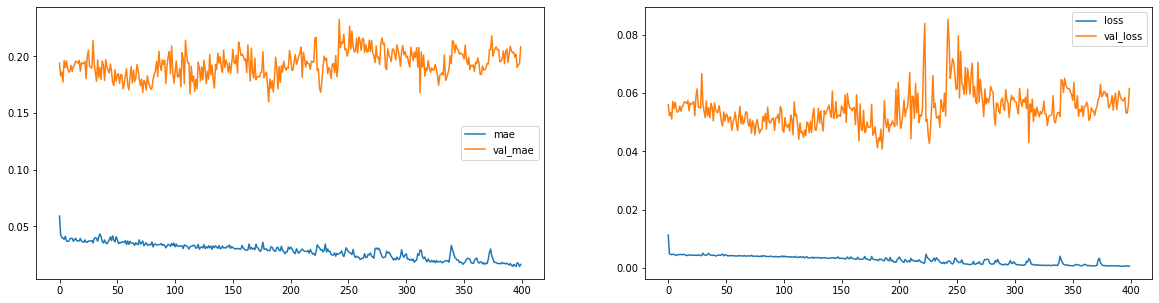

In [21]:
mae_hist_2 = history2.history['mae']
val_mae_hist_2 = history2.history['val_mae']
loss_hist_2 = history2.history['loss']
val_loss_hist_2 = history2.history['val_loss']

epochs2 = range(len(mae_hist_2))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs2, mae_hist_2, label='mae')
plt.plot(epochs2, val_mae_hist_2, label='val_mae')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs2, loss_hist_2, label='loss')
plt.plot(epochs2, val_loss_hist_2, label='val_loss')
plt.legend()

181/181 [==============================] - 1s 5ms/step
mae 3842.55908203125
mape 2.9556312561035156
rmse 4794.905629936839


,actual,prediction
0,129550,124103.968750
1,128900,124215.109375
2,128500,124157.085938
3,128350,123755.382812
4,127950,122925.109375
...,...,...
229,128700,125508.914062
230,130950,125586.398438
231,133850,125377.265625
232,128450,125439.210938


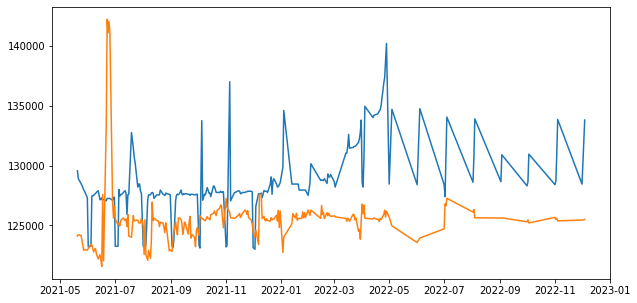

In [22]:
prediction_2_adam = forecast_predict(model1, test_dagingsapi1_, time_size=win_size, batch_size=5)
data_result_2_adam = prediction_2_adam[(len(x_train)) - win_size:-1, -1]
data_result_2_adam = scal_range.inverse_transform(data_result_2_adam.reshape(-1, 1))
data_result_2_adam = data_result_2_adam.reshape(-1)
mae_2_adam = mean_absolute_error(x_test, data_result_2_adam)
mape_2_adam = mean_absolute_percentage_error(x_test, data_result_2_adam)
mse_2_adam = mean_squared_error(x_test, data_result_2_adam)
rmse_2_adam = math.sqrt(mse_2_adam)

print(f'mae {mae_2_adam.numpy()}\nmape {mape_2_adam.numpy()}\nrmse {rmse_2_adam}')

data_2_adam = pd.DataFrame()
data_2_adam['actual'] = x_test
data_2_adam['prediction'] = data_result_2_adam
data_2_adam.to_csv('dagingsapi1_2_adam.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_2_adam.actual)
plt.plot(y_test, data_2_adam.prediction)
data_2_adam

#### SGD

In [23]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])

In [24]:
history3 = model1.fit(data_train, epochs=400, validation_data=data_val)

Epoch 1/400
84/84 [==============================] - 1s 15ms/step - loss: 7.2196e-04 - mae: 0.0170 - mape: 4.1457 - val_loss: 0.0534 - val_mae: 0.1923 - val_mape: 45.6639
Epoch 2/400
84/84 [==============================] - 1s 14ms/step - loss: 0.0020 - mae: 0.0232 - mape: 5.7861 - val_loss: 0.0540 - val_mae: 0.1928 - val_mape: 45.2618
Epoch 3/400
84/84 [==============================] - 1s 13ms/step - loss: 9.3269e-04 - mae: 0.0196 - mape: 4.8506 - val_loss: 0.0580 - val_mae: 0.2033 - val_mape: 50.4332
Epoch 4/400
84/84 [==============================] - 1s 13ms/step - loss: 0.0024 - mae: 0.0267 - mape: 6.6486 - val_loss: 0.0629 - val_mae: 0.2087 - val_mape: 46.5177
Epoch 5/400
84/84 [==============================] - 1s 13ms/step - loss: 0.0025 - mae: 0.0271 - mape: 6.7190 - val_loss: 0.0550 - val_mae: 0.1962 - val_mape: 46.2524
Epoch 6/400
84/84 [==============================] - 1s 16ms/step - loss: 0.0016 - mae: 0.0232 - mape: 5.7991 - val_loss: 0.0606 - val_mae: 0.2068 - val_mape

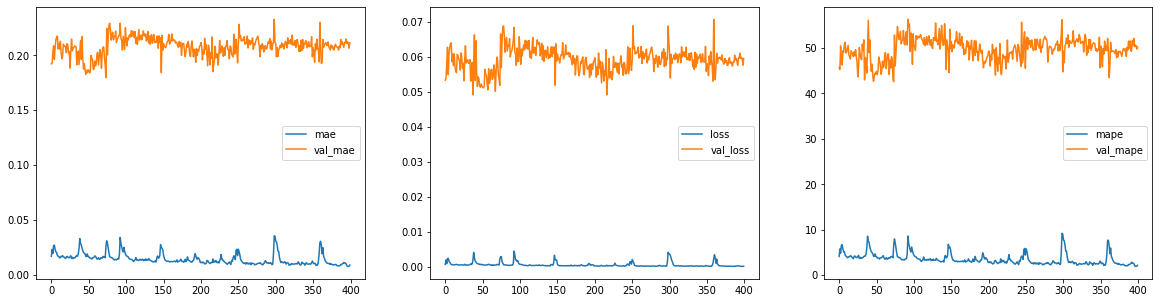

In [25]:
mae_hist_3 = history3.history['mae']
val_mae_hist_3 = history3.history['val_mae']
loss_hist_3 = history3.history['loss']
val_loss_hist_3 = history3.history['val_loss']
mape_hist_3 = history3.history['mape']
val_mape_hist_3 = history3.history['val_mape']

epochs3 = range(len(mae_hist_3))

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs3, mae_hist_3, label='mae')
plt.plot(epochs3, val_mae_hist_3, label='val_mae')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(epochs3, loss_hist_3, label='loss')
plt.plot(epochs3, val_loss_hist_3, label='val_loss')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(epochs3, mape_hist_3, label='mape')
plt.plot(epochs3, val_mape_hist_3, label='val_mape')
plt.legend()

181/181 [==============================] - 1s 4ms/step
mae 3537.404541015625
mape 2.7189784049987793
rmse 4511.867905867813


,actual,prediction
0,129550,126511.171875
1,128900,126539.250000
2,128500,125638.476562
3,128350,125549.031250
4,127950,124948.000000
...,...,...
229,128700,125879.390625
230,130950,125702.562500
231,133850,125968.218750
232,128450,126153.937500


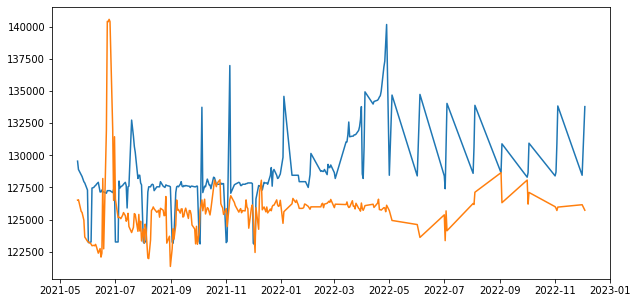

In [26]:
prediction_2_sgd = forecast_predict(model1, test_dagingsapi1_, time_size=win_size, batch_size=5)
data_result_2_sgd = prediction_2_sgd[(len(x_train)) - win_size:-1, -1]
data_result_2_sgd = scal_range.inverse_transform(data_result_2_sgd.reshape(-1, 1))
data_result_2_sgd = data_result_2_sgd.reshape(-1)
mae_2_sgd = mean_absolute_error(x_test, data_result_2_sgd)
mape_2_sgd = mean_absolute_percentage_error(x_test, data_result_2_sgd)
mse_2_sgd = mean_squared_error(x_test, data_result_2_sgd)
rmse_2_sgd = math.sqrt(mse_2_sgd)

print(f'mae {mae_2_sgd.numpy()}\nmape {mape_2_sgd.numpy()}\nrmse {rmse_2_sgd}')

data_2_sgd = pd.DataFrame()
data_2_sgd['actual'] = x_test
data_2_sgd['prediction'] = data_result_2_sgd
data_2_sgd.to_csv('dagingsapi1_2_sgd.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_2_sgd.actual)
plt.plot(y_test, data_2_sgd.prediction)
data_2_sgd